In [1]:
# general packages
import numpy as np
import os
import sys
import inspect

# H-FISTA packages
currentdir = %pwd 
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from lib import Residual
from fista import fista
from helpers import get_data
from lambda_loop import take_lambda_step, initialize_io_dict, get_initial_lambda
from stopping import check_stopping

# plotting tools
import matplotlib.pyplot as plt
from plotting import make_plots, get_diag_plot, get_paper_figure, get_dynamic_field_plot
from scipy.fft import fftshift

%matplotlib inline

# plot style adjustement, remove if jupyter themes not avaiable
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, ticks=True, grid=False,)

# further plot configuration
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.aspect"] = "auto"
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams["axes.linewidth"] = 3

In [2]:
from plotting import make_plots, get_diag_plot

import sys
import importlib
importlib.reload(sys.modules["plotting"])
from plotting import make_plots

### Load and plot data

2022-10-27 10:24:28,441 - H-FISTA.helpers - WARNING - Loading data/simulated/simulated_12.5percent_noisefree.pkl as a psrflux ASCII file failed. Trying to load as a FITS file.
2022-10-27 10:24:28,444 - H-FISTA.helpers - WARNING - Loading data/simulated/simulated_12.5percent_noisefree.pkl as a FITS file failed. Trying to load as a pickle


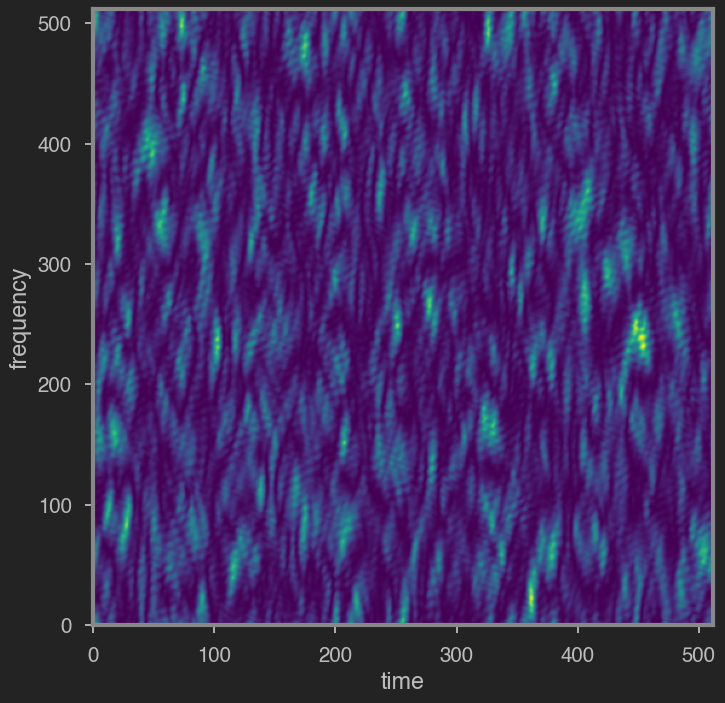

In [3]:
data = get_data("data/simulated/simulated_12.5percent_noisefree.pkl")

plt.imshow(data.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

## H-FISTA
### Generate initial values

In [4]:
# initial RFI mask does not mask any data
mask = np.ones_like(data)

# initial guess with all power in one wave at the origin
N, M = data.shape
h_init = np.zeros((N, M)) + np.zeros((N, M)) * 1.0j

init_value = np.sqrt(np.mean(data * mask)) * N * M + 0.0j
init_coords = [0, 0]
h_init[init_coords[0], init_coords[1]] = init_value

# H-FISTA configuration
lambda_scale = 1.15
desired_components = 60
fix_phase_value = 0.0
fix_phase_coords = init_coords

# FISTA configuration
FISTA_niter = 80
delay_for_inf = -4
backtrack = True
verbose = False

### Initialise I/O dictionary

In [5]:
# pre-populate the rest of the input output dictionary
io = initialize_io_dict()

# setup the initial guess as a step so that we can use the exact same loop for all runs below
step = 0

io["niters"][step] = 0 

# mask = np.ones_like(data) # in this particular case, we already have a mask
io["masks"][step] = mask
resid = Residual(data, h_init, None, mask)
io["lambdas"][step] = get_initial_lambda(desired_components, delay_for_inf, resid) * lambda_scale
io["models"][step] = h_init
io["demerits"][step] = -1
io["predictions"][step] = resid.prediction
io["residuals"][step] = resid.residual

In [6]:
chosen_step = -1

approved = np.transpose(np.nonzero(h_init))

# in this case, the stopping criteria will never trigger so we manually shorten the number of iterations
# we know the number of iterations necessary from a previous run
for step in range(1, 67):
    io["niters"][step] = FISTA_niter
    ref_lambda = io["lambdas"][step-1]/lambda_scale

    lambda_loop_config = {
        "backtrack": backtrack,
        "fix_phase_value": fix_phase_value,
        "fix_phase_coords": init_coords,
        "ref_lambda": ref_lambda, 
        "verbose": verbose,
        "delay_for_inf": delay_for_inf,
        "zero_penalty_coords": approved,
        "clean_RFI": False, # RFI cleaning can get overly eager in noise free cases
    }

    print()
    print(f"### λ iteration {step} with λ={ref_lambda} and scaling {lambda_scale} ###")
    print() 

    approved = take_lambda_step(data, io, step, **lambda_loop_config)
    io["lambdas"][step] = ref_lambda
    
    if step > 1:
        if check_stopping(io, step):
            chosen_step = step - 1
            print(f"Stopping criterion triggered in step {step}")
            break


### λ iteration 1 with λ=7.757199794060385e-08 and scaling 1.15 ###

2022-10-27 10:24:29,038 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1 components (approved: 1 and fixed support 0)
2022-10-27 10:24:29,492 - H-FISTA.fista - INFO - backtrack_B3 found 2.14e-09 after 4 iterations. Model has 60 el.
2022-10-27 10:24:29,519 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 60 non-zero elements with demerit 0.00194
2022-10-27 10:24:31,840 - H-FISTA.fista - INFO - backtrack_B3 found 2.36e-09 after 1 iterations. Model has 62 el.
2022-10-27 10:24:34,990 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 64 non-zero elements with demerit 0.00165
2022-10-27 10:24:38,161 - H-FISTA.fista - INFO - Arrived at model with 65 components/ 0.00165 after 80 iterations
2022-10-27 10:24:38,183 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 65 components (approved: 0 and fixed support 65)
2022-10-27 10:24:38,185 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10

2022-10-27 10:25:57,935 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 2 with threshold 19.687484887742567
2022-10-27 10:25:57,937 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 5 with λ=4.4352041589676355e-08 and scaling 1.15 ###

2022-10-27 10:25:57,966 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 130 components (approved: 130 and fixed support 0)
2022-10-27 10:25:58,064 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 140 non-zero elements with demerit 0.000752
2022-10-27 10:25:59,021 - H-FISTA.fista - INFO - backtrack_B3 found 2.59e-09 after 6 iterations. Model has 139 el.
2022-10-27 10:26:03,961 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 140 non-zero elements with demerit 0.000748
2022-10-27 10:26:06,931 - H-FISTA.fista - INFO - Arrived at model with 140 components/ 0.000748 after 80 iterations
2022-10-27 10:26:06,950 - H-FISTA.fista - INFO - Running FISTA from an initial guess w

2022-10-27 10:27:11,505 - H-FISTA.fista - INFO - backtrack_B3 found 1.95e-09 after 1 iterations. Model has 112 el.
2022-10-27 10:27:11,922 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 4 iterations. Model has 112 el.
2022-10-27 10:27:16,291 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 112 non-zero elements with demerit 9.3e-05
2022-10-27 10:27:19,114 - H-FISTA.fista - INFO - Arrived at model with 112 components/ 9.3e-05 after 80 iterations
2022-10-27 10:27:19,118 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 3 with threshold 11.768037172227455
2022-10-27 10:27:19,119 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 8 with λ=2.9162187286710852e-08 and scaling 1.15 ###

2022-10-27 10:27:19,138 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 112 components (approved: 112 and fixed support 0)
2022-10-27 10:27:19,222 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 128 non-zero elem

2022-10-27 10:28:28,746 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 173 non-zero elements with demerit 2.73e-05
2022-10-27 10:28:31,145 - H-FISTA.fista - INFO - Arrived at model with 173 components/ 2.73e-05 after 80 iterations
2022-10-27 10:28:31,149 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 8.141380271451418
2022-10-27 10:28:31,150 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 12 with λ=1.6673575229768825e-08 and scaling 1.15 ###

2022-10-27 10:28:31,168 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 173 components (approved: 173 and fixed support 0)
2022-10-27 10:28:31,291 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 184 el.
2022-10-27 10:28:31,309 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 184 non-zero elements with demerit 2.69e-05
2022-10-27 10:28:32,028 - H-FISTA.fista - INFO - backtrack_B3 found 3.13e-09 after 7 i

2022-10-27 10:29:41,071 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 246 non-zero elements with demerit 7.78e-06
2022-10-27 10:29:41,654 - H-FISTA.fista - INFO - backtrack_B3 found 2.14e-09 after 3 iterations. Model has 246 el.
2022-10-27 10:29:42,101 - H-FISTA.fista - INFO - backtrack_B3 found 2.59e-09 after 2 iterations. Model has 246 el.
2022-10-27 10:29:45,393 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 246 non-zero elements with demerit 7.09e-06
2022-10-27 10:29:47,762 - H-FISTA.fista - INFO - Arrived at model with 246 components/ 7.09e-06 after 80 iterations
2022-10-27 10:29:47,765 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 3.679731694711019
2022-10-27 10:29:47,767 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 17 with λ=8.289713698486898e-09 and scaling 1.15 ###

2022-10-27 10:29:47,790 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 246 components (approve

2022-10-27 10:30:47,369 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 21 with λ=4.739670712146912e-09 and scaling 1.15 ###

2022-10-27 10:30:47,390 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 309 components (approved: 309 and fixed support 0)
2022-10-27 10:30:47,473 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 326 non-zero elements with demerit 2.23e-06
2022-10-27 10:30:48,164 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 7 iterations. Model has 326 el.
2022-10-27 10:30:51,563 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 326 non-zero elements with demerit 2.18e-06
2022-10-27 10:30:53,726 - H-FISTA.fista - INFO - Arrived at model with 326 components/ 2.18e-06 after 80 iterations
2022-10-27 10:30:53,740 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 326 components (approved: 0 and fixed support 326)
2022-10-27 10:30:53,741 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:

2022-10-27 10:31:42,121 - H-FISTA.fista - INFO - backtrack_B3 found 1.95e-09 after 1 iterations. Model has 384 el.
2022-10-27 10:31:42,394 - H-FISTA.fista - INFO - backtrack_B3 found 2.36e-09 after 2 iterations. Model has 384 el.
2022-10-27 10:31:45,772 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 384 non-zero elements with demerit 6.18e-07
2022-10-27 10:31:47,986 - H-FISTA.fista - INFO - Arrived at model with 384 components/ 6.18e-07 after 80 iterations
2022-10-27 10:31:48,001 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 384 components (approved: 0 and fixed support 384)
2022-10-27 10:31:48,002 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:31:48,119 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 384 el.
2022-10-27 10:31:48,134 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 384 non-zero elements with demerit 5.41e-07
2022-10-27 10:31:48,463 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 iterations

2022-10-27 10:32:37,128 - H-FISTA.fista - INFO - backtrack_B3 found 2.14e-09 after 4 iterations. Model has 437 el.
2022-10-27 10:32:37,705 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 3 iterations. Model has 437 el.
2022-10-27 10:32:40,833 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 437 non-zero elements with demerit 2.08e-07
2022-10-27 10:32:42,973 - H-FISTA.fista - INFO - Arrived at model with 437 components/ 2.08e-07 after 80 iterations
2022-10-27 10:32:42,987 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 437 components (approved: 0 and fixed support 437)
2022-10-27 10:32:42,987 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:32:43,126 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 437 el.
2022-10-27 10:32:43,152 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 437 non-zero elements with demerit 1.85e-07
2022-10-27 10:32:43,590 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 iterations

2022-10-27 10:33:31,618 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 498 el.
2022-10-27 10:33:31,632 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 498 non-zero elements with demerit 5.86e-08
2022-10-27 10:33:32,923 - H-FISTA.fista - INFO - backtrack_B3 found 3.45e-09 after 8 iterations. Model has 498 el.
2022-10-27 10:33:37,076 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 498 non-zero elements with demerit 5.78e-08
2022-10-27 10:33:39,164 - H-FISTA.fista - INFO - backtrack_B3 found 5.05e-09 after 4 iterations. Model has 498 el.
2022-10-27 10:33:39,475 - H-FISTA.fista - INFO - backtrack_B3 found 6.11e-09 after 2 iterations. Model has 498 el.
2022-10-27 10:33:39,777 - H-FISTA.fista - INFO - Arrived at model with 498 components/ 5.78e-08 after 80 iterations
2022-10-27 10:33:39,791 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 498 components (approved: 0 and fixed support 498)
2022-10-27 10:33:39,791 - H-FISTA.fista - IN

2022-10-27 10:34:24,215 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 37 with λ=5.065038193148742e-10 and scaling 1.15 ###

2022-10-27 10:34:24,235 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 539 components (approved: 539 and fixed support 0)
2022-10-27 10:34:24,307 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 553 non-zero elements with demerit 1.48e-08
2022-10-27 10:34:24,661 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 553 el.
2022-10-27 10:34:25,406 - H-FISTA.fista - INFO - backtrack_B3 found 3.13e-09 after 7 iterations. Model has 553 el.
2022-10-27 10:34:28,494 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 553 non-zero elements with demerit 1.43e-08
2022-10-27 10:34:29,917 - H-FISTA.fista - INFO - backtrack_B3 found 3.45e-09 after 1 iterations. Model has 553 el.
2022-10-27 10:34:30,156 - H-FISTA.fista - INFO - backtrack_B3 found 4.59e-09 after 3 iterations. Model ha

2022-10-27 10:35:19,021 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 578 non-zero elements with demerit 4.41e-09
2022-10-27 10:35:19,973 - H-FISTA.fista - INFO - backtrack_B3 found 3.13e-09 after 3 iterations. Model has 578 el.
2022-10-27 10:35:20,656 - H-FISTA.fista - INFO - backtrack_B3 found 6.72e-09 after 8 iterations. Model has 578 el.
2022-10-27 10:35:21,885 - H-FISTA.fista - INFO - Arrived at model with 578 components/ 4.41e-09 after 80 iterations
2022-10-27 10:35:21,897 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 578 components (approved: 0 and fixed support 578)
2022-10-27 10:35:21,898 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:35:21,969 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 578 non-zero elements with demerit 3.49e-09
2022-10-27 10:35:22,295 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 578 el.
2022-10-27 10:35:22,838 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 iterations

2022-10-27 10:36:18,402 - H-FISTA.fista - INFO - backtrack_B3 found 1.27e-06 after 1 iterations. Model has 588 el.
2022-10-27 10:36:18,777 - H-FISTA.fista - INFO - backtrack_B3 found 1.69e-06 after 3 iterations. Model has 588 el.
2022-10-27 10:36:19,183 - H-FISTA.fista - INFO - backtrack_B3 found 2.72e-06 after 5 iterations. Model has 588 el.
2022-10-27 10:36:19,312 - H-FISTA.fista - INFO - backtrack_B3 found 3e-06 after 1 iterations. Model has 588 el.
2022-10-27 10:36:19,467 - H-FISTA.fista - INFO - Arrived at model with 588 components/ 2.01e-09 after 80 iterations
2022-10-27 10:36:19,471 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 8.40646874499491e-05
2022-10-27 10:36:19,473 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 43 with λ=2.1897557852442095e-10 and scaling 1.15 ###

2022-10-27 10:36:19,493 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 588 components (approved: 588 a

2022-10-27 10:36:57,755 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 616 el.
2022-10-27 10:36:58,296 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 iterations. Model has 616 el.
2022-10-27 10:36:58,589 - H-FISTA.fista - INFO - backtrack_B3 found 2.59e-09 after 4 iterations. Model has 616 el.
2022-10-27 10:37:01,125 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 1 iterations. Model has 616 el.
2022-10-27 10:37:01,281 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 616 non-zero elements with demerit 3.86e-10
2022-10-27 10:37:01,509 - H-FISTA.fista - INFO - backtrack_B3 found 3.45e-09 after 2 iterations. Model has 616 el.
2022-10-27 10:37:02,097 - H-FISTA.fista - INFO - backtrack_B3 found 4.17e-09 after 2 iterations. Model has 616 el.
2022-10-27 10:37:02,300 - H-FISTA.fista - INFO - backtrack_B3 found 4.59e-09 after 1 iterations. Model has 616 el.
2022-10-27 10:37:02,568 - H-FISTA.fista - INFO - backtrack_B3 found 5.05e-0

2022-10-27 10:37:37,638 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.03820256972544772
2022-10-27 10:37:37,639 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 49 with λ=9.466918542680516e-11 and scaling 1.15 ###

2022-10-27 10:37:37,661 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 627 components (approved: 627 and fixed support 0)
2022-10-27 10:37:37,731 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 627 non-zero elements with demerit 8.84e-11
2022-10-27 10:37:39,477 - H-FISTA.fista - INFO - backtrack_B3 found 5.55e-09 after 14 iterations. Model has 627 el.
2022-10-27 10:37:39,610 - H-FISTA.fista - INFO - backtrack_B3 found 6.11e-09 after 1 iterations. Model has 627 el.
2022-10-27 10:37:40,147 - H-FISTA.fista - INFO - backtrack_B3 found 1.08e-08 after 6 iterations. Model has 627 el.
2022-10-27 10:37:40,470 - H-FISTA.fista - INFO - backtrack_B3 found 1.31e-08 after 2 itera

2022-10-27 10:38:35,754 - H-FISTA.fista - INFO - Fixing support
2022-10-27 10:38:35,876 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 631 el.
2022-10-27 10:38:35,890 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 631 non-zero elements with demerit 6.02e-11
2022-10-27 10:38:36,899 - H-FISTA.fista - INFO - backtrack_B3 found 3.13e-09 after 7 iterations. Model has 631 el.
2022-10-27 10:38:39,740 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 631 non-zero elements with demerit 4.84e-11
2022-10-27 10:38:41,718 - H-FISTA.fista - INFO - Arrived at model with 631 components/ 4.84e-11 after 80 iterations
2022-10-27 10:38:41,723 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.026260573793055665
2022-10-27 10:38:41,724 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 51 with λ=7.158350504862395e-11 and scaling 1.15 ###

2022-10-27 10:38:41,745 - H-FISTA.fista - INFO

2022-10-27 10:39:23,357 - H-FISTA.fista - INFO - backtrack_B3 found 5.31e-06 after 1 iterations. Model has 633 el.
2022-10-27 10:39:23,373 - H-FISTA.fista - INFO - Arrived at model with 633 components/ 3.26e-11 after 80 iterations
2022-10-27 10:39:23,377 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 1.1729488887225535e-05
2022-10-27 10:39:23,379 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 53 with λ=5.4127414025424545e-11 and scaling 1.15 ###

2022-10-27 10:39:23,405 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 633 components (approved: 633 and fixed support 0)
2022-10-27 10:39:23,474 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 635 non-zero elements with demerit 3.22e-11
2022-10-27 10:39:23,790 - H-FISTA.fista - INFO - backtrack_B3 found 1.61e-09 after 1 iterations. Model has 635 el.
2022-10-27 10:39:24,344 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 i

2022-10-27 10:40:18,057 - H-FISTA.fista - INFO - backtrack_B3 found 1.89e-07 after 1 iterations. Model has 638 el.
2022-10-27 10:40:18,395 - H-FISTA.fista - INFO - backtrack_B3 found 2.08e-07 after 1 iterations. Model has 638 el.
2022-10-27 10:40:18,549 - H-FISTA.fista - INFO - backtrack_B3 found 2.28e-07 after 1 iterations. Model has 638 el.
2022-10-27 10:40:18,640 - H-FISTA.fista - INFO - Arrived at model with 638 components/ 1.17e-11 after 80 iterations
2022-10-27 10:40:18,645 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.00020598804587687854
2022-10-27 10:40:18,646 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 55 with λ=4.092810134247603e-11 and scaling 1.15 ###

2022-10-27 10:40:18,665 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 638 components (approved: 638 and fixed support 0)
2022-10-27 10:40:18,738 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 640 non-zero ele

2022-10-27 10:40:52,246 - H-FISTA.fista - INFO - Arrived at model with 641 components/ 4.29e-12 after 80 iterations
2022-10-27 10:40:52,250 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.0022461643050742807
2022-10-27 10:40:52,252 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 57 with λ=3.0947524644594353e-11 and scaling 1.15 ###

2022-10-27 10:40:52,274 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 641 components (approved: 641 and fixed support 0)
2022-10-27 10:40:54,419 - H-FISTA.fista - INFO - backtrack_B3 found 5.47e-08 after 38 iterations. Model has 641 el.
2022-10-27 10:40:54,434 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 641 non-zero elements with demerit 4.29e-12
2022-10-27 10:41:05,153 - H-FISTA.fista - INFO - backtrack_B3 found 4 after 190 iterations. Model has 641 el.
2022-10-27 10:41:06,494 - H-FISTA.fista - INFO - backtrack_B3 found 26.9 after 20 iteration

2022-10-27 10:41:40,075 - H-FISTA.fista - INFO - backtrack_B3 found 1.54e-06 after 31 iterations. Model has 642 el.
2022-10-27 10:41:40,327 - H-FISTA.fista - INFO - backtrack_B3 found 1.86e-06 after 2 iterations. Model has 642 el.
2022-10-27 10:41:40,677 - H-FISTA.fista - INFO - backtrack_B3 found 2.25e-06 after 2 iterations. Model has 642 el.
2022-10-27 10:41:40,995 - H-FISTA.fista - INFO - backtrack_B3 found 3.3e-06 after 4 iterations. Model has 642 el.
2022-10-27 10:41:43,523 - H-FISTA.fista - INFO - backtrack_B3 found 0.000149 after 40 iterations. Model has 642 el.
2022-10-27 10:41:44,531 - H-FISTA.fista - INFO - backtrack_B3 found 0.000685 after 16 iterations. Model has 642 el.
2022-10-27 10:41:45,436 - H-FISTA.fista - INFO - backtrack_B3 found 0.00147 after 8 iterations. Model has 642 el.
2022-10-27 10:41:50,406 - H-FISTA.fista - INFO - backtrack_B3 found 6.45 after 88 iterations. Model has 642 el.
2022-10-27 10:41:50,420 - H-FISTA.fista - INFO - Arrived at model with 642 compone

2022-10-27 10:42:32,222 - H-FISTA.fista - INFO - backtrack_B3 found 1.77e-09 after 1 iterations. Model has 645 el.
2022-10-27 10:42:32,452 - H-FISTA.fista - INFO - backtrack_B3 found 2.36e-09 after 3 iterations. Model has 645 el.
2022-10-27 10:42:35,205 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 645 non-zero elements with demerit 8.35e-13
2022-10-27 10:42:35,979 - H-FISTA.fista - INFO - backtrack_B3 found 2.59e-09 after 1 iterations. Model has 645 el.
2022-10-27 10:42:36,172 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 1 iterations. Model has 645 el.
2022-10-27 10:42:36,423 - H-FISTA.fista - INFO - backtrack_B3 found 3.13e-09 after 1 iterations. Model has 645 el.
2022-10-27 10:42:37,309 - H-FISTA.fista - INFO - Arrived at model with 645 components/ 8.35e-13 after 80 iterations
2022-10-27 10:42:37,313 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.006491212215628033
2022-10-27 10:42:37,315 - H-FISTA.lambda_loop - INFO -

2022-10-27 10:43:09,869 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 647 non-zero elements with demerit 3.42e-13
2022-10-27 10:43:10,129 - H-FISTA.fista - INFO - backtrack_B3 found 1.72e-07 after 4 iterations. Model has 647 el.
2022-10-27 10:43:10,963 - H-FISTA.fista - INFO - backtrack_B3 found 4.9e-07 after 11 iterations. Model has 647 el.
2022-10-27 10:43:11,082 - H-FISTA.fista - INFO - backtrack_B3 found 5.39e-07 after 1 iterations. Model has 647 el.
2022-10-27 10:43:11,510 - H-FISTA.fista - INFO - backtrack_B3 found 7.17e-07 after 3 iterations. Model has 647 el.
2022-10-27 10:43:11,627 - H-FISTA.fista - INFO - backtrack_B3 found 7.89e-07 after 1 iterations. Model has 647 el.
2022-10-27 10:43:12,067 - H-FISTA.fista - INFO - backtrack_B3 found 1.4e-06 after 6 iterations. Model has 647 el.
2022-10-27 10:43:12,607 - H-FISTA.fista - INFO - backtrack_B3 found 3.3e-06 after 9 iterations. Model has 647 el.
2022-10-27 10:43:12,861 - H-FISTA.fista - INFO - backtrack_B3 found 3.62e-06 

2022-10-27 10:43:45,426 - H-FISTA.fista - INFO - backtrack_B3 found 2.11e-08 after 1 iterations. Model has 647 el.
2022-10-27 10:43:46,154 - H-FISTA.fista - INFO - Arrived at model with 647 components/ 7.21e-33 after 80 iterations
2022-10-27 10:43:46,158 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.0005516717473168492
2022-10-27 10:43:46,159 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data

### λ iteration 65 with λ=1.0116800702465878e-11 and scaling 1.15 ###

2022-10-27 10:43:46,178 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 647 components (approved: 647 and fixed support 0)
2022-10-27 10:43:46,545 - H-FISTA.fista - INFO - backtrack_B3 found 2.59e-09 after 6 iterations. Model has 647 el.
2022-10-27 10:43:46,558 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 647 non-zero elements with demerit 4.4e-33
2022-10-27 10:43:47,050 - H-FISTA.fista - INFO - backtrack_B3 found 2.85e-09 after 1 ite

2022-10-27 10:44:14,573 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 0.00023546640401329004
2022-10-27 10:44:14,574 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.00 per cent of data


### Inspect dynamic field progression

#### Plot the magnitude and phase of the dynamic field H

We note that that the magnitude of H is the square root of the dynamic spectrum

We plot the dynamic field for the first three λ iterations, and the last step

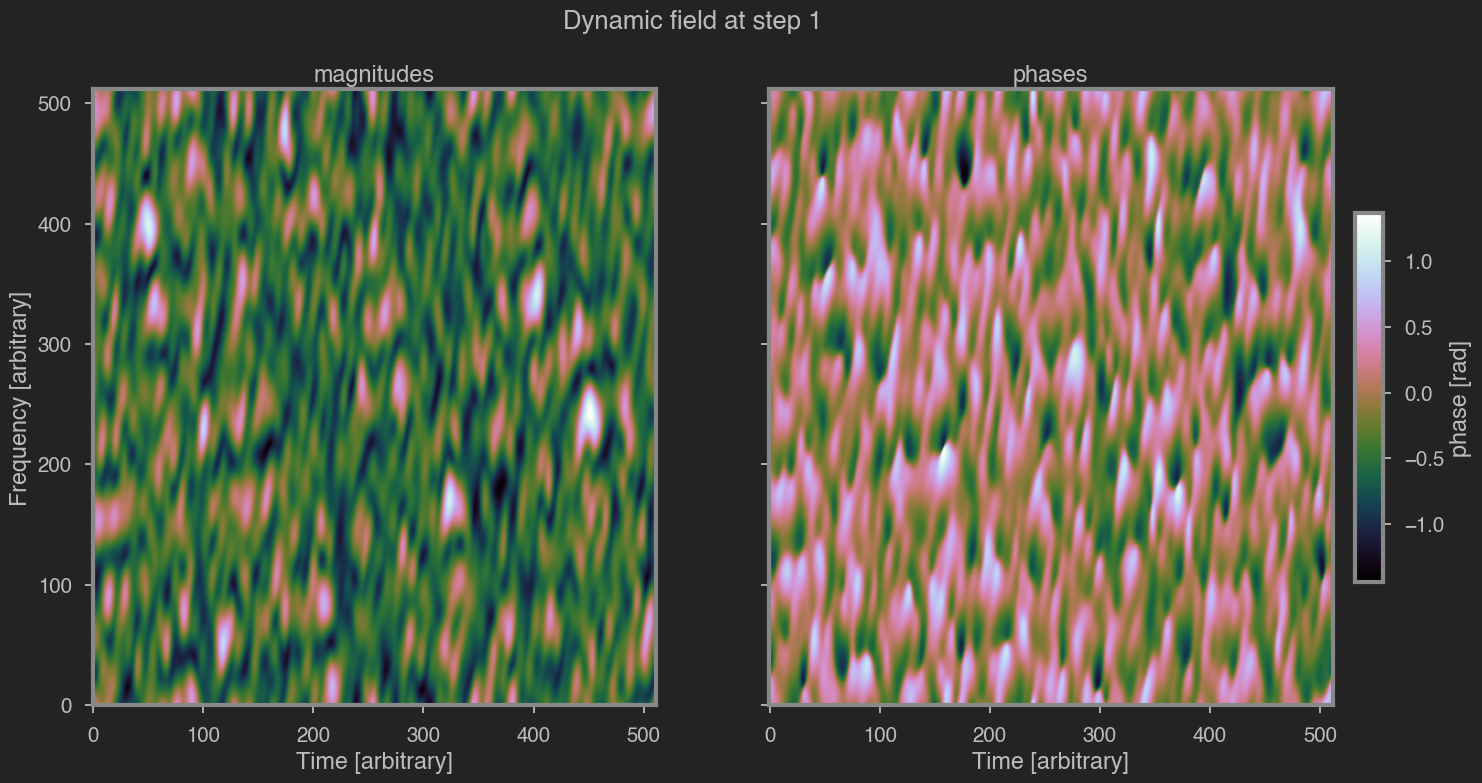

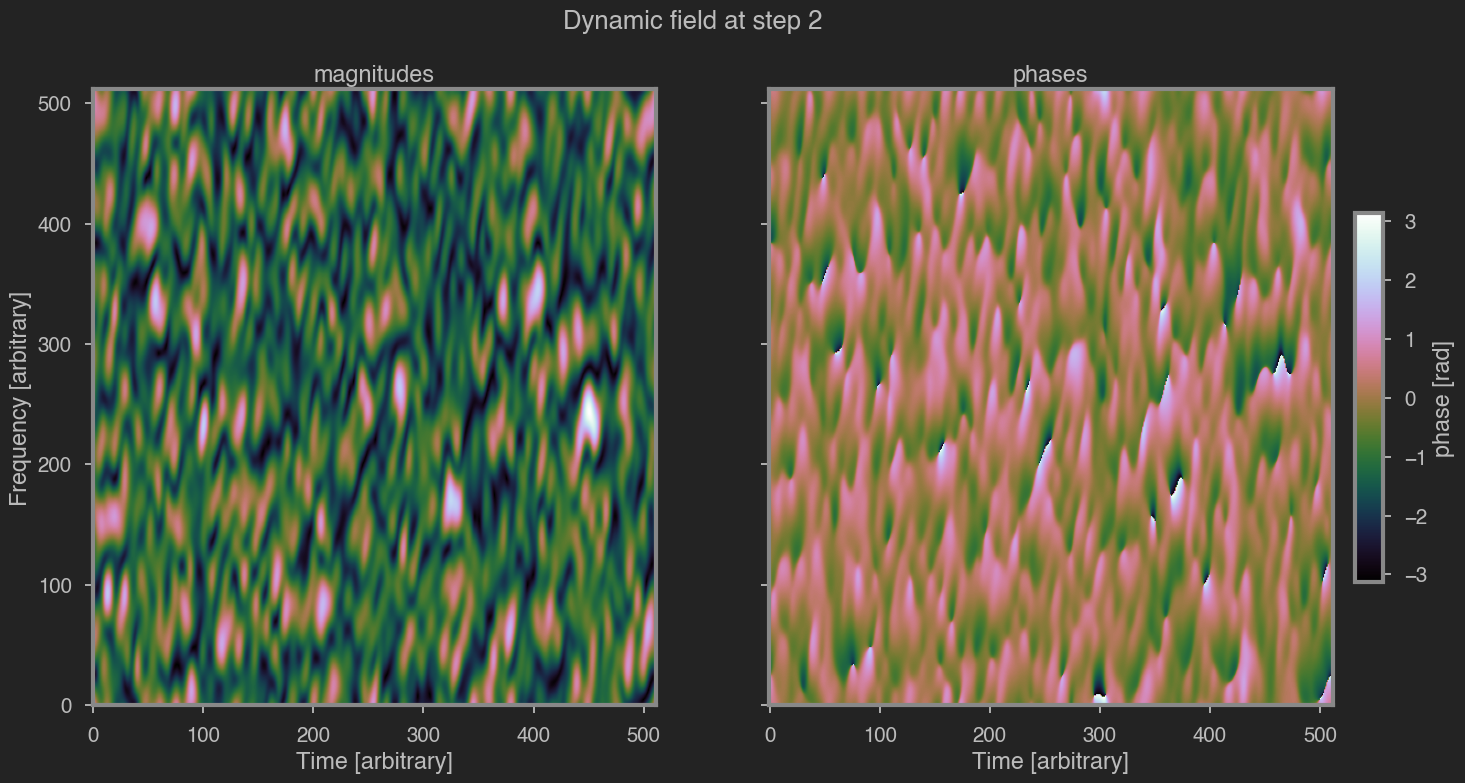

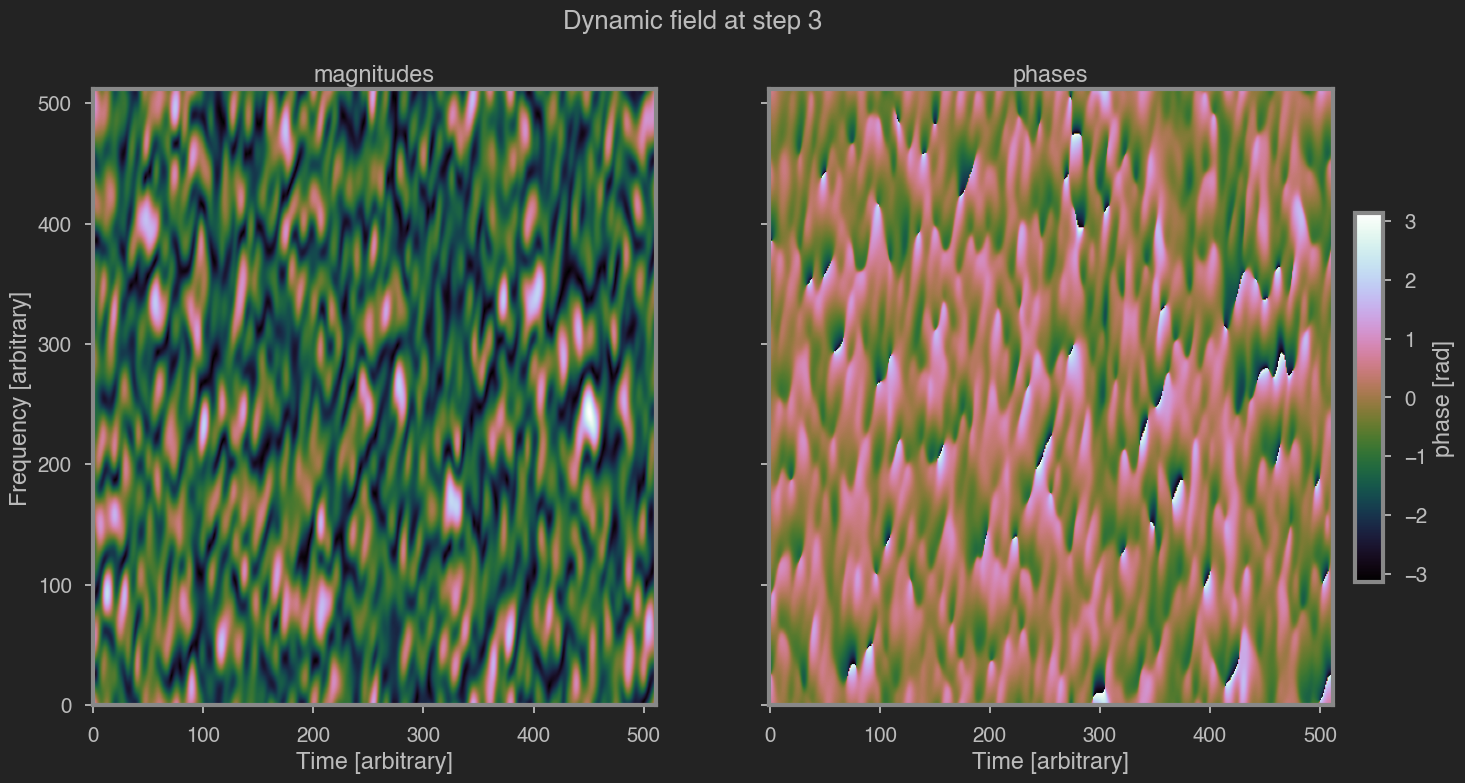

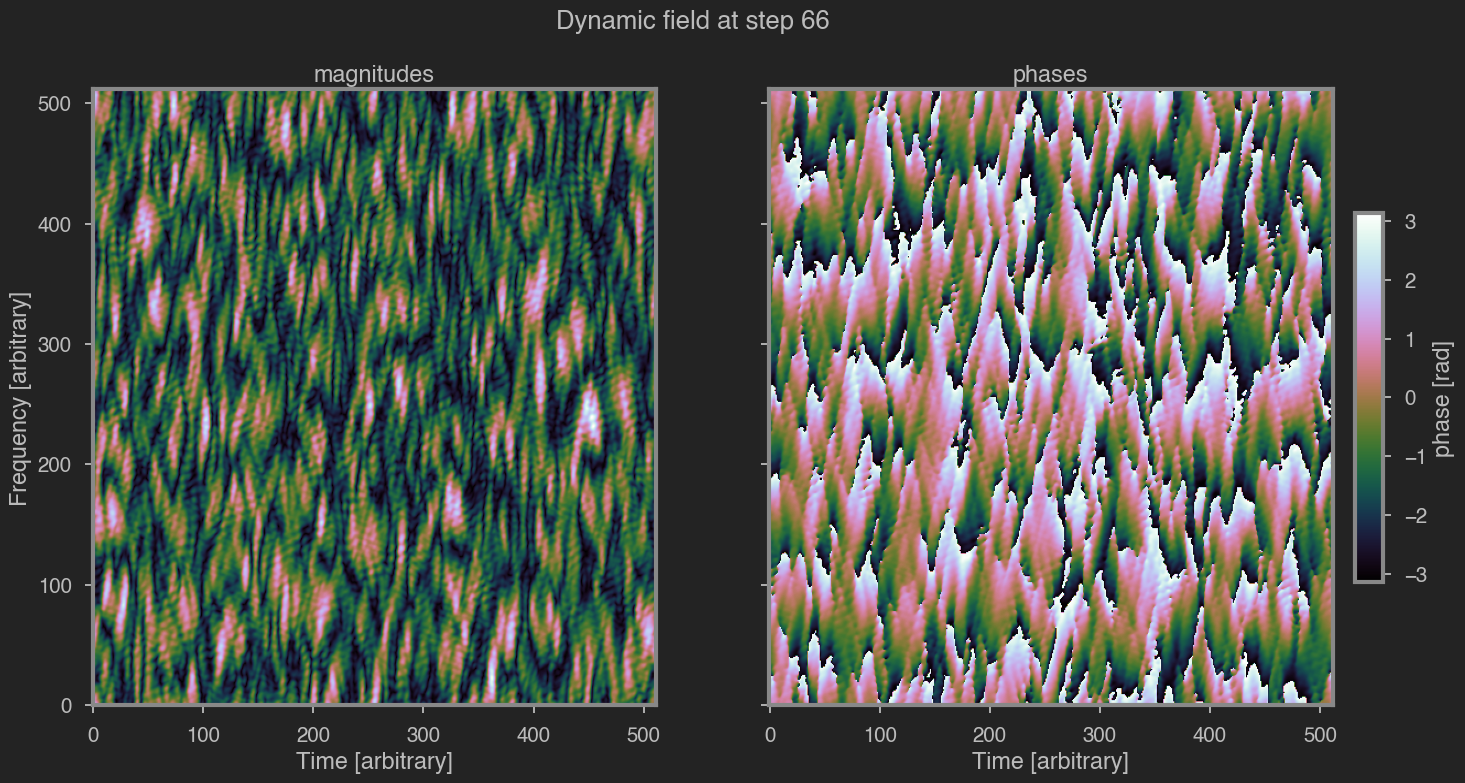

In [7]:
inspect_steps = [1, 2, 3]

if chosen_step > 0:
    inspect_steps.append(chosen_step)
else:
    inspect_steps.append(np.max(list(io["models"].keys())))

for _step in inspect_steps:
    get_dynamic_field_plot(data, io, _step)

### Diagnostic plot

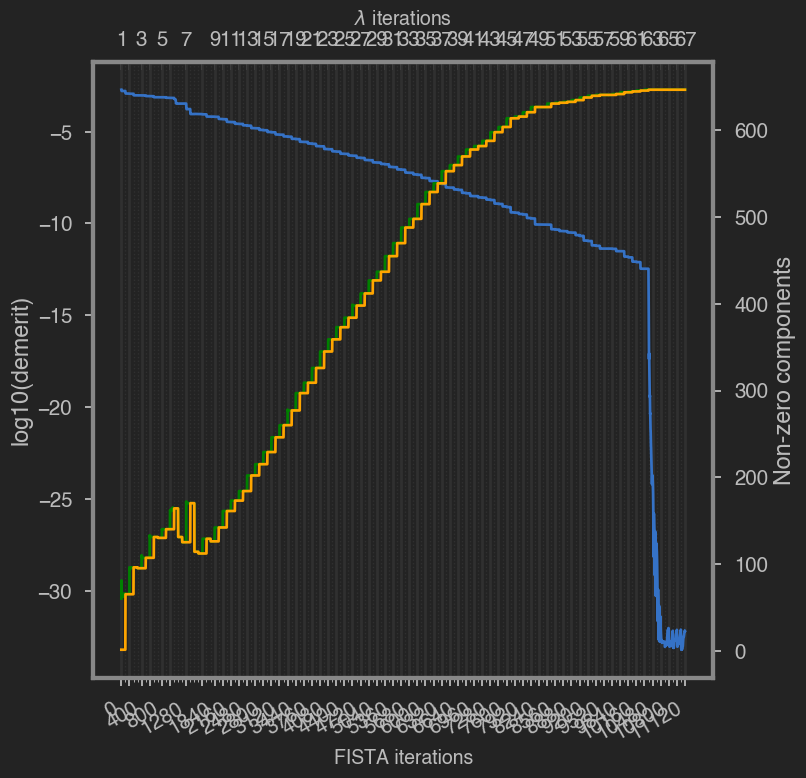

In [8]:
get_diag_plot(io)

/Users/sosl/work/Manly/HFISTA/plotting.py:379: RuntimeWarning: divide by zero encountered in log10
  wf_log10_abs = np.log10(np.power(np.abs(fftshift(wavefield)), 2))


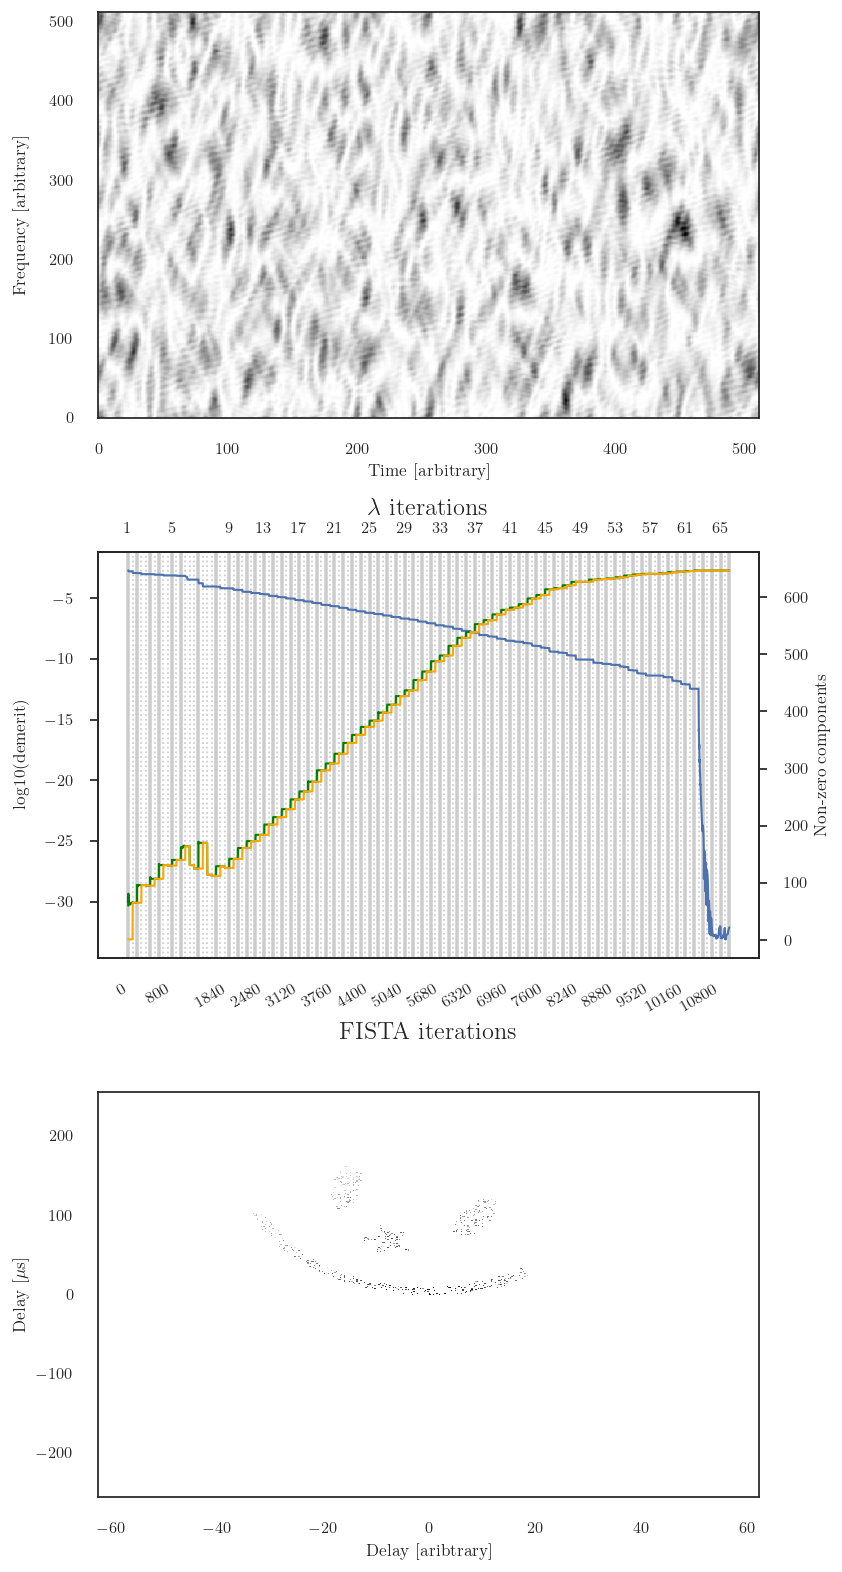

In [9]:
fig, axs = get_paper_figure(
    io,
    data,
    chosen_step=65,
    outfn="fig_125_noise_free.eps",
    tick_step=4,
    dense=False,
    vmin_data=0,
)

In [11]:
import pickle

with open("output/simulated_12.5_NF_io.pkl", "wb") as fh:
    pickle.dump(io, fh)